<b><font size=20, color='#A020F0'>Animations

Hannah Zanowski<br>
12/3/21<br>

#### Resources
[matplotlib animation](https://matplotlib.org/stable/api/animation_api.html#animation)<br>
[ffmpeg download](https://ffmpeg.org/download.html)

Other animation tools <br>
[Celluloid](https://pypi.org/project/celluloid/)<br>
[Plotly](https://plotly.com/python/animations/)<br>
[Python CLI for VisIt](https://visit-sphinx-github-user-manual.readthedocs.io/en/develop/cli_manual/index.html)<br>
[VisIt](https://visit-dav.github.io/visit-website/index.html) (this is not a python package)

Some examples:<br>
[Animated Schrödinger Equation](https://jakevdp.github.io/blog/2012/09/05/quantum-python/)<br>
[Animation in Jupyter notebooks tutorial](https://jckantor.github.io/CBE30338/A.03-Animation-in-Jupyter-Notebooks.html)<br>

# A little about today's lecture
Today we'll be using matplotlib to learn how to make animations. Animations are another really useful tool for visualizing data, especially if you want to show how something is changing in time. Unfortunately, because the AOS jupyterhub is being a colossal _tool_, you will not get to run your own animations in class today as you follow along with lecture. However, you'll at least have this code to refer to if you ever want to make animations in your own python environment.

## matplotlib.animation
Matplotlib has a set of tools for making animations called...[animation](https://matplotlib.org/stable/api/animation_api.html). But first let's use a python magic to make things interactive in your notebook:

In [1]:
#This command makes plots interactive in jupyterlab
%matplotlib widget

In [2]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import animation

## Basic Animation
Matplotlib has several ways to make an animation, but a common method is to use [FuncAnimation](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html#matplotlib.animation.FuncAnimation) to create an animation by repeatedly calling a function that creates a frame for the animation. 

In this example, we'll animate the location of a point on a circle over time. Below we'll go through the steps you need to follow in order to create an animation:

### 1. Set up the figure
This is where you create the initial setup for your plot. Think of it as a snapshot of the first frame in your animation

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
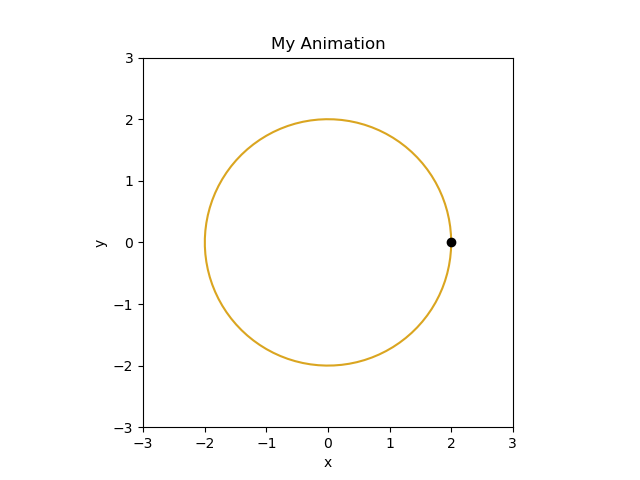

In [3]:
#make the circle for the plot
r=2
theta=np.linspace(0,2*np.pi,100)
x=r*np.cos(theta)
y=r*np.sin(theta)

fig,ax=plt.subplots()
plt.plot(x,y,color='goldenrod')
pt,=ax.plot(x[0],y[0],marker='o',color='k',zorder=3) #zorder sets the layer number, i.e, whether or not your
#point is behind the circle or on top of it)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_aspect('equal')
plt.title('My Animation');
plt.xlabel('x');
plt.ylabel('y');

### 2. Initialize the background for each frame
Here you want to set the parts of the plot that _will_ change to be blank, by setting up a function that draws a clean frame. In this case the only thing we need to make blank is our single plot point as that's the only thing that will be changing in our animation.

In [4]:
def frame_init():
    pt.set_data([],[]) #set the data for the plot point to be empty
    return pt

### 3. Create the animation function
This is the function that creates each new frame with the updated location of the scatterplot point

In [5]:
def animate(i):
    pt.set_data(x[i],y[i]) #set the data for the plot point to be at each x,y from above
    return pt

### 4. Put it all together
Once you have your intialization function and your animation function, provide these as arguments to `FuncAnimation()` and then use `plt.show()` to show the animation.

<font size=3><b>NOTE:</b> To <b><font color='red'>_stop_</font></b> an animation, hit the stop button in the top panel of your notebook or run `anim.event_source.stop()`</font>


Arguments to `FuncAnimation()`
1. `frames` is the number of frames that will be generated. This is the value that `i` takes on in your animate function in step 3. In this case I've set frames to be the length of the data so that the point can make it all the way around the circle!
2. `interval` is the interval between frames in milliseconds
3. `blit=True` tells python to only redraw things that have changed from one from to the next. This can save a lot of time!
4. `repeat=True` although not set below, this is the default. It tells python to repreat the animation once the sequence of frames is completed

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
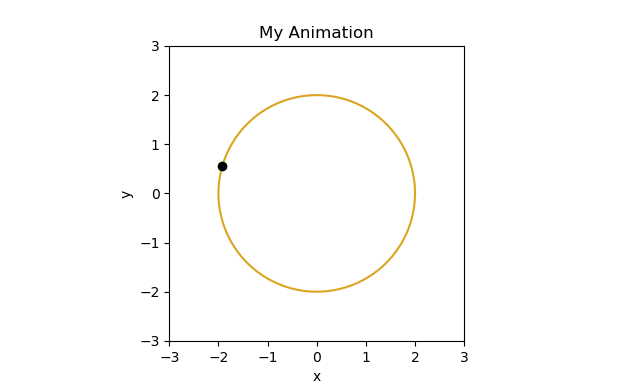

In [8]:
anim=animation.FuncAnimation(fig,animate,init_func=frame_init,frames=50,interval=10,blit=True)
plt.show()

In [9]:
anim.event_source.stop()

### Saving animations
You can save the animations, but it requires an encoder like [ffmpeg](https://ffmpeg.org/download.html) to be installed, which is not the case on the AOS jupyterhub. However, here is an example of what the code to save an animation as an mp4 could look like:
```bash
anim.save('my_animation.mp4', fps=20, extra_args=['-vcodec', 'libx264'])
```

---

## An example with data!
Here I'll show you how to make an animation using the HadISST data we used in an earlier lecture.

In [3]:
ds=xr.open_dataset('../Lectures/HadISST_201501_201912.nc')
ds

<xarray.Dataset>
Dimensions:    (time: 60, nv: 2, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2019-12-16T12:00:00
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 ...
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    14/9/2021 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

For this example, let's make a "climatology" out of the 5 years of SST data that we have. We'll also need to reindex the latitudes and get rid of the missing values

In [4]:
ds=ds.reindex(latitude=list(reversed(ds.latitude))) #reindex latitude
land=np.isnan(ds.sst[0]) #land mask
ds=ds.where(ds.sst>-1000) #
ds=ds.groupby('time.month').mean('time')
ds

<xarray.Dataset>
Dimensions:    (month: 12, nv: 2, latitude: 180, longitude: 360)
Coordinates:
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nv
Data variables:
    time_bnds  (month, nv, latitude, longitude) float32 nan nan ... 5.406e+04
    sst        (month, latitude, longitude) float32 nan nan nan ... -1.8 -1.8

### Make a plot
First we'll set up a nice cartopy plot for showing the SSTs

Text(0.5, 1.0, 'Jan')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
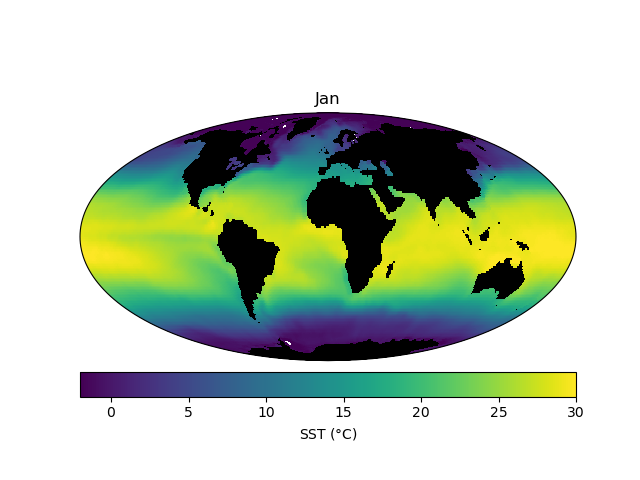

In [5]:
fig,ax=plt.subplots(subplot_kw={'projection':ccrs.Mollweide()})
cs0=ax.pcolormesh(ds.longitude,ds.latitude,land,cmap=plt.cm.gray_r,transform=ccrs.PlateCarree())
cs1=ax.pcolormesh(ds.longitude,ds.latitude,ds.sst[0],transform=ccrs.PlateCarree(),vmin=-2,vmax=30)
cbar=plt.colorbar(cs1,orientation='horizontal',pad=0.03)
cbar.set_label('SST ($\degree$C)')
plt.title('Jan')

### Set up the animation function
Instead of making an initialization function like we did last time, here we'll just redraw the contour plot for each frame by first setting the pcolormesh contour collections to an empty set. This helps keep the animation from running really slowly.

In [6]:
titles=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
def animate(i):
    ax.collections=[] #reset all the contour collections
    cs0=ax.pcolormesh(ds.longitude,ds.latitude,land,cmap=plt.cm.gray_r,transform=ccrs.PlateCarree())
    cs1=ax.pcolormesh(ds.longitude,ds.latitude,ds.sst[i],transform=ccrs.PlateCarree(),vmin=-2,vmax=30)
    plt.title(titles[i])
    return cs1

### Make the animation

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
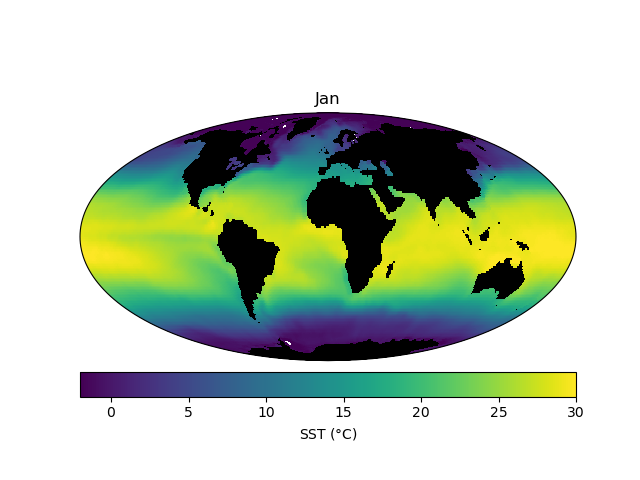

In [7]:
anim=animation.FuncAnimation(fig,animate,frames=12,interval=10,blit=True)
plt.show()

In [8]:
#stop the animation
anim.event_source.stop()